In [2]:
import os
import numpy as np
import decoy_mnist
from matplotlib import pyplot as plt

from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Multiply, Reshape
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.losses import kld
from keras.datasets import mnist
from keras import backend as K

### Load decoy MNIST

In [8]:
Xr, x_train, y_train, E, Xtr, x_test, y_test, Et = decoy_mnist.generate_dataset(cachefile='data/decoy-mnist.npz')
x_train = x_train / 255 / 5 + 4/5
x_test = x_test / 255 / 5 + 4/5
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Load normal MNIST

In [9]:
def load_mnist():
    print('Loading MNIST')
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1) / 255 / 5 + 4 / 5
    x_test = np.expand_dims(x_test, -1) / 255 / 5 + 4 / 5
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)


(x_train_g, y_train_g), (x_test_g, y_test_g) = load_mnist()

Loading MNIST


## Model looking at corner splotches

In [11]:
def ConvNet(train):
    if train or not os.path.isfile('classifier_d.hdf5'):
        print('Classifier model is being trained')
        inputs = Input([28, 28, 1])
        x = Conv2D(32, (3, 3), activation='relu', name='conv1')(inputs)
        x = Conv2D(64, (3, 3), activation='relu', name='conv2')(x)
        x = MaxPool2D((2, 2), name='mp1')(x)
        x = Conv2D(64, (3, 3), activation='relu', name='conv3')(x)
        x = Conv2D(128, (3, 3), activation='relu', name='conv4')(x)
        x = Flatten(name='flatten')(x)
        x = Dense(10, activation='softmax', name='dense1')(x)
        
        model = Model(inputs, x)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x_train, y_train, batch_size=1000, epochs=15, validation_split=1/6)
        model.save('classifier_d.hdf5')
    else:
        print('Classifier model loaded')
        model = load_model('classifier_d.hdf5')
    return model

In [12]:
convnet1 = ConvNet(train=True)
convnet1.trainable = False
print(convnet1.evaluate(x_test, y_test))
print(convnet1.evaluate(x_test_g, y_test_g))

Classifier model is being trained
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s - loss: 1.2557 - acc: 0.6086 - val_loss: 0.4305 - val_acc: 0.8731
Epoch 2/15
50000/50000 [==============================] - 2s - loss: 0.3941 - acc: 0.8847 - val_loss: 0.2928 - val_acc: 0.9133
Epoch 3/15
50000/50000 [==============================] - 2s - loss: 0.2611 - acc: 0.9240 - val_loss: 0.1852 - val_acc: 0.9525
Epoch 4/15
50000/50000 [==============================] - 2s - loss: 0.1770 - acc: 0.9486 - val_loss: 0.1527 - val_acc: 0.9574
Epoch 5/15
50000/50000 [==============================] - 2s - loss: 0.1332 - acc: 0.9600 - val_loss: 0.1111 - val_acc: 0.9692
Epoch 6/15
50000/50000 [==============================] - 2s - loss: 0.1066 - acc: 0.9685 - val_loss: 0.1052 - val_acc: 0.9687
Epoch 7/15
50000/50000 [==============================] - 2s - loss: 0.0923 - acc: 0.9723 - val_loss: 0.0923 - val_acc: 0.9736
Epoch 8/15
50000/50000 [===

We see that model is robust and performs well on both decoy MNIST and regular MNIST test sets.

### Explaining robust model

In [13]:
model = convnet1

In [20]:
def normalized_kld(p, q):
    return 1 - K.exp(-kld(p, q))

def ExplanationModel(reg, train):
    if train or not os.path.isfile('exp_model_d.hdf5'):
        inputs = Input(shape=x_train.shape[1:])

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPool2D((2, 2))(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPool2D((2, 2))(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

        x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='attention', activity_regularizer=l2(reg))(x)

        x = Multiply()([x, inputs])
        x = model(x)

        exp_model = Model(inputs, x)

        y_train = model.predict(x_train)
        exp_model.compile(optimizer='adam', loss=normalized_kld)
        exp_model.summary()
        for l in exp_model.layers[-1].layers:
            l.trainable = False
        exp_model.fit(x_train, y_train, epochs=5)
        exp_model.save('exp_model_d.hdf5')
    else:
        exp_model = load_model('exp_model_d.hdf5', compile=False)
        exp_model.compile(optimizer='sgd', loss=normalized_kld)
    return exp_model

In [21]:
exp_model = ExplanationModel(reg=0.0001, train=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 28, 28, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 14, 14, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

Processing image #1


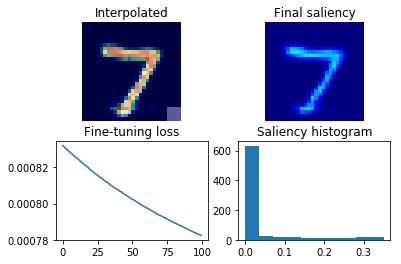

Processing image #2


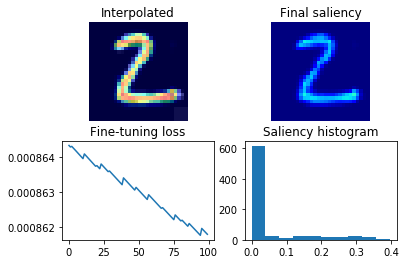

Processing image #3


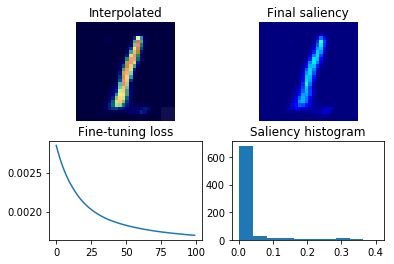

Processing image #4


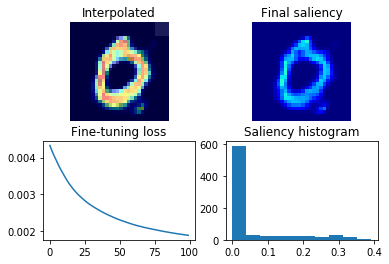

Processing image #5


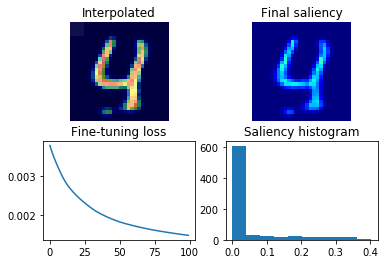

In [27]:
exp_model = load_model('exp_model_d.hdf5', compile=False)
saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
saliency_values = saliency([x_test])[0]
prediction = model.predict(x_test, batch_size=1000)
y = model.predict(x_test)

for i in range(5):
    print('Processing image #{}'.format(i+1))
    exp_model = load_model('exp_model_d.hdf5', compile=False)
    opt = SGD(lr=0.01)
    exp_model.compile(optimizer=opt, loss=normalized_kld)
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])

    img = x_test[i, :, :, 0]

    plt.subplot(3, 3, 2)
    plt.axis('off')
    plt.title('Interpolated')
    plt.imshow(img, cmap='gray')
    orig_sal = saliency_values[i].reshape((28, 28))
    sal_interp = (orig_sal - orig_sal.min()) / (orig_sal.max() - orig_sal.min())
    plt.imshow(sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(3, 3, 1)
    plt.axis('off')
    plt.title('Original saliency')
    plt.imshow(orig_sal, cmap='jet', vmin=0, vmax=1)

    for l in exp_model.layers[-1].layers:
        l.trainable = False
    hist = exp_model.fit(x_test[i:i + 1], y[i:i + 1], epochs=100, verbose=False)
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
    final_sal = saliency([x_test[i:i + 1]])[0].reshape((28, 28))
    final_sal_interp = (final_sal - final_sal.min()) / (final_sal.max() - final_sal.min())

    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.title('Interpolated')
    plt.imshow(img, cmap='gray')
    plt.imshow(final_sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.title('Final saliency')
    plt.imshow(final_sal, cmap='jet', vmin=0, vmax=1)


    plt.subplot(2, 2, 3)
    plt.title('Fine-tuning loss')
    plt.plot(hist.history['loss'])

    plt.subplot(2, 2, 4)
    plt.title('Saliency histogram')
    plt.hist(orig_sal.flatten())

    plt.show()

Saliency maps show that model is not paying attention to corner splotches.

## Model looking at corner splotches

In [29]:
def ConvNet2(train):
    if train or not os.path.isfile('classifier_d2.hdf5'):
        print('Classifier model is being trained')
        inputs = Input([28, 28, 1])
        x = Flatten(name='flatten')(inputs)
        x = Dense(1024, activation='relu', name='dense1')(x)
        x = Dense(10, activation='softmax', name='dense2')(x)
        
        model = Model(inputs, x)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(x_train, y_train, batch_size=100, epochs=30, validation_split=1/6)
        model.save('classifier_d2.hdf5')
    else:
        print('Classifier model loaded')
        model = load_model('classifier_d2.hdf5')
    return model

In [39]:
convnet2 = ConvNet2(train=True)
convnet2.trainable = False
print(convnet2.evaluate(x_test, y_test))
print(convnet2.evaluate(x_test_g, y_test_g))

Classifier model is being trained
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 1s - loss: 1.7570 - acc: 0.4419 - val_loss: 0.9759 - val_acc: 0.7866
Epoch 2/30
50000/50000 [==============================] - 1s - loss: 0.8072 - acc: 0.7631 - val_loss: 0.6999 - val_acc: 0.7979
Epoch 3/30
50000/50000 [==============================] - 1s - loss: 0.5737 - acc: 0.8281 - val_loss: 0.4813 - val_acc: 0.8640
Epoch 4/30
50000/50000 [==============================] - 1s - loss: 0.4818 - acc: 0.8550 - val_loss: 0.4362 - val_acc: 0.8714
Epoch 5/30
50000/50000 [==============================] - 1s - loss: 0.4515 - acc: 0.8628 - val_loss: 0.3813 - val_acc: 0.8915
Epoch 6/30
50000/50000 [==============================] - 1s - loss: 0.4046 - acc: 0.8789 - val_loss: 0.3897 - val_acc: 0.8852
Epoch 7/30
50000/50000 [==============================] - 1s - loss: 0.3663 - acc: 0.8904 - val_loss: 0.2898 - val_acc: 0.9153
Epoch 8/30
50000/50000 [===

Model performs well on training decoy data but fails badly on test decoy data and even worse on normal test data.

### Explaining bad model

In [40]:
model = convnet2

In [41]:
exp_model = ExplanationModel(reg=0.00001, train=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 28, 28, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 14, 14, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

Processing image #1


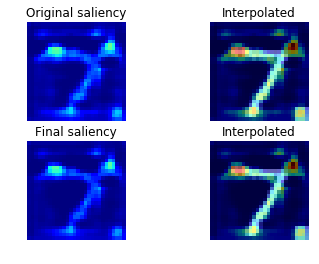

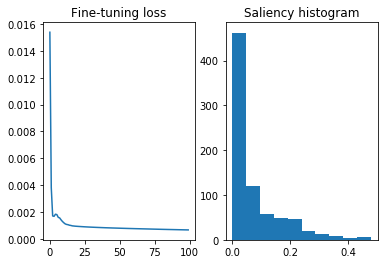

Processing image #2


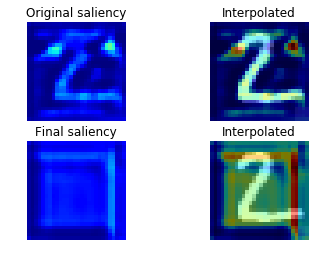

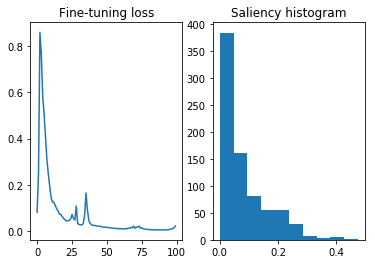

Processing image #3


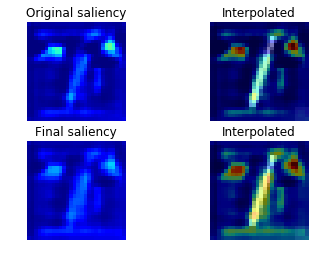

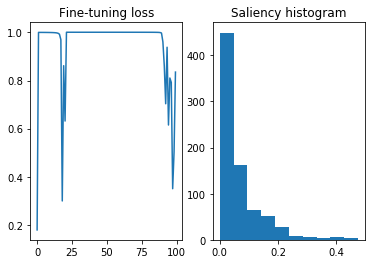

Processing image #4


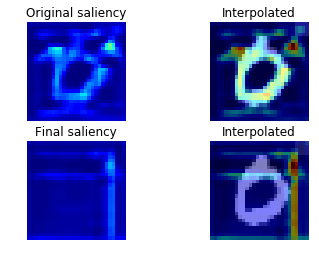

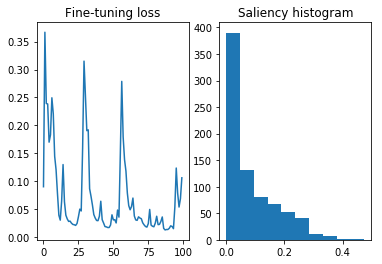

Processing image #5


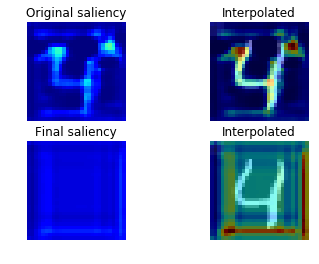

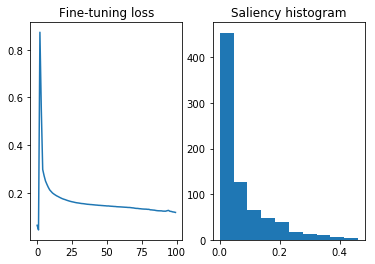

Processing image #6


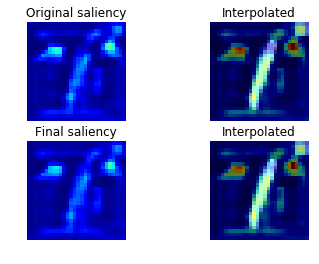

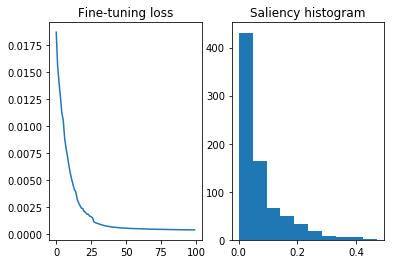

Processing image #7


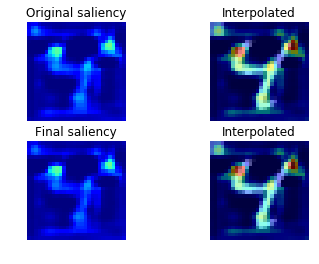

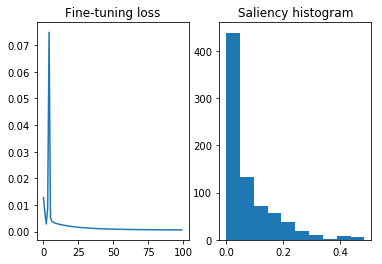

Processing image #8


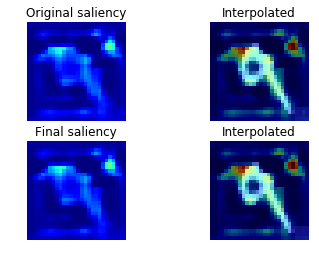

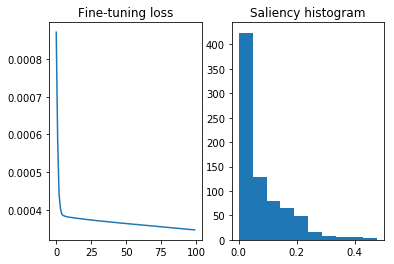

Processing image #9


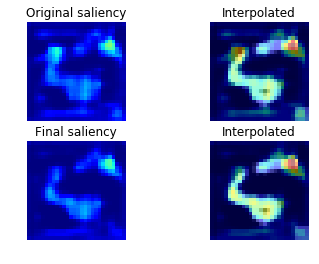

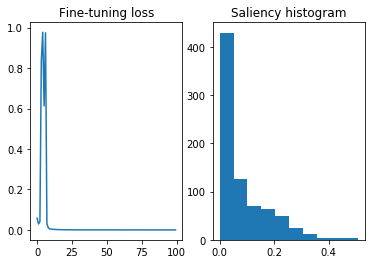

Processing image #10


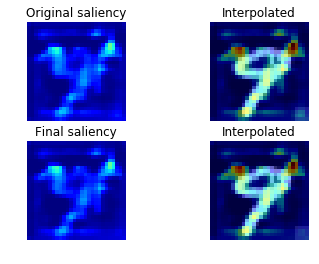

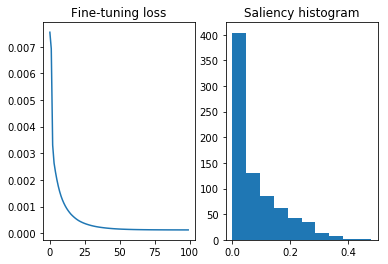

Processing image #11


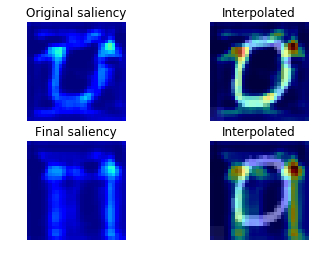

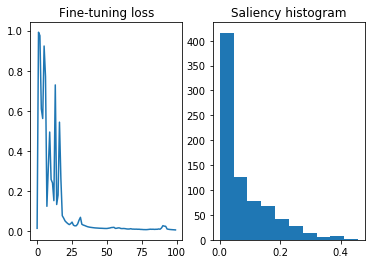

Processing image #12


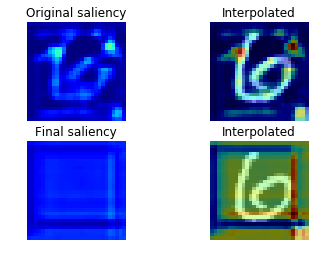

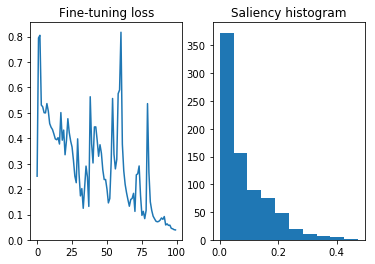

Processing image #13


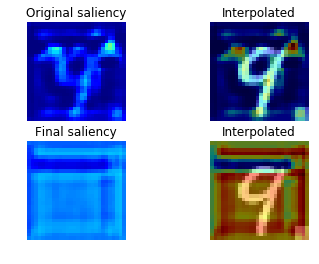

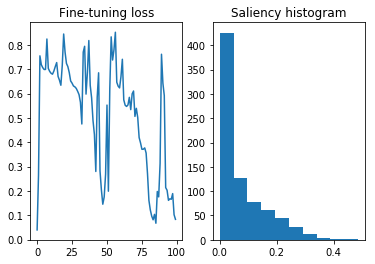

Processing image #14


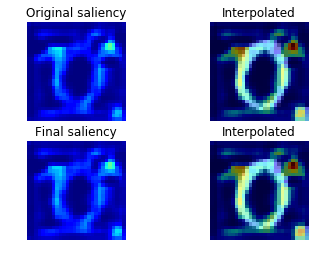

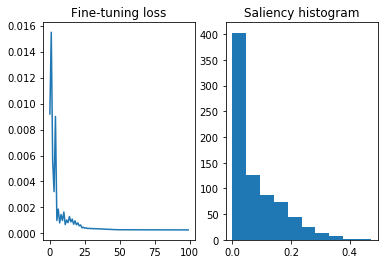

Processing image #15


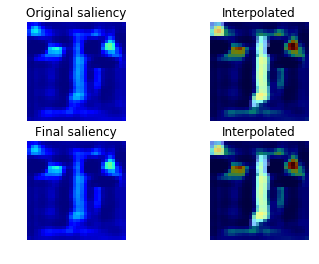

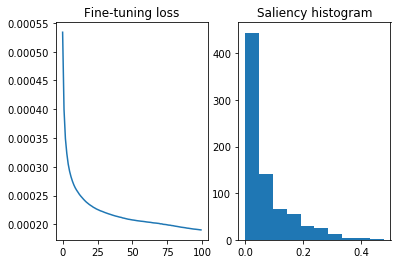

In [42]:
exp_model = load_model('exp_model_d.hdf5', compile=False)
saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])

saliency_values = saliency([x_test])[0]
prediction = model.predict(x_test, batch_size=1000)
y = model.predict(x_test)

for i in range(15):
    print('Processing image #{}'.format(i+1))
    exp_model = load_model('exp_model_d.hdf5', compile=False)
    opt = SGD(lr=0.01)
    exp_model.compile(optimizer=opt, loss=normalized_kld)

    img = x_test[i, :, :, 0]

    plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.title('Interpolated')
    plt.imshow(img, cmap='gray')
    orig_sal = saliency_values[i].reshape((28, 28))
    sal_interp = (orig_sal - orig_sal.min()) / (orig_sal.max() - orig_sal.min())
    plt.imshow(sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.title('Original saliency')
    plt.imshow(orig_sal, cmap='jet', vmin=0, vmax=1)

    hist = exp_model.fit(x_test[i:i + 1], y[i:i + 1], epochs=100, verbose=False)
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
    final_sal = saliency([x_test[i:i + 1]])[0].reshape((28, 28))
    final_sal_interp = (final_sal - final_sal.min()) / (final_sal.max() - final_sal.min())

    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.title('Interpolated')
    plt.imshow(img, cmap='gray')
    plt.imshow(final_sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(2, 2, 3)
    plt.axis('off')
    plt.title('Final saliency')
    plt.imshow(final_sal, cmap='jet', vmin=0, vmax=1)
    plt.show()
    
    plt.subplot(1, 2, 1)
    plt.title('Fine-tuning loss')
    plt.plot(hist.history['loss'])

    plt.subplot(1, 2, 2)
    plt.title('Saliency histogram')
    plt.hist(orig_sal.flatten())

    plt.show()

Explanations show that this bad model is indeed looking at corner splotches.